In [2]:
#!pip install nltk sklearn wordcloud pymorphy2 stop_words

  Running setup.py bdist_wheel for stop-words: started
  Running setup.py bdist_wheel for stop-words: finished with status 'done'
  Stored in directory: C:\Users\Sergey\AppData\Local\pip\Cache\wheels\75\37\6a\2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [11]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## RegExp crash course

https://regex101.com

https://regexr.com

In [12]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [13]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [14]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [15]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [16]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [17]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [18]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [19]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [20]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [21]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [22]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [23]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

# Обработка реального текста

In [24]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [25]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

---

In [26]:
DATA_PATH = 'positive.csv'

In [27]:
df = pd.read_csv(DATA_PATH, header=None, sep=';',
                 names=['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 
                        'tfol', 'tfrien', 'listcount'])
print(df.shape)

(114911, 12)


In [28]:
df.head()

,id,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [29]:
df.dtypes

id            int64
tdate         int64
tmane        object
ttext        object
ttype         int64
trep          int64
trtw          int64
tfav          int64
tstcount      int64
tfol          int64
tfrien        int64
listcount     int64
dtype: object

---

In [30]:
corpus, texts = [], []

for message in log_progress(df.ttext.dropna().as_matrix()):
    sp = message.split('\n')
    corpus += sp
    texts += sp
#     break

print(len(corpus), len(texts))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


141685 141685


In [31]:
corpus[4265]

'RT @GrigoriySergeev: Новое поколение картографов) http://t.co/zpewVrjOMA'

**Уберем ссылки:**

In [32]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
print(len(corpus))

141685


In [33]:
corpus[4265]

'RT @GrigoriySergeev: Новое поколение картографов) '

**Уберем лишние пробелы:**

In [35]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

141685


In [36]:
corpus[4265]

'RT @GrigoriySergeev: Новое поколение картографов)'

**Уберем другие лишние символы:**

In [37]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [39]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

141685


In [40]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

141685


In [41]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

141685


In [42]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

141685


In [43]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

141685


In [44]:
corpus[4265]

'RT GrigoriySergeev Новое поколение картографов'

In [45]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

140239
140239


In [46]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

140239


In [47]:
corpus[1040]

'lilarchi и nezlayaa ребята поздравляем вас от души любви вам и гармонии молодцы'

In [48]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

140239


In [49]:
corpus[100]

'теперь буду ждать лето'

In [50]:
morph = pymorphy2.MorphAnalyzer()

In [51]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

128207 140239


In [52]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

140239
128207


In [53]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [54]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

128207


In [55]:
corpus_tokens[100]

['радостных', 'выходных', 'помощью']

In [56]:
corpus_tokens_stem[100]

['радостн', 'выходн', 'помощ']

---

In [39]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

128207 128207


In [40]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

128207


(0, 30)

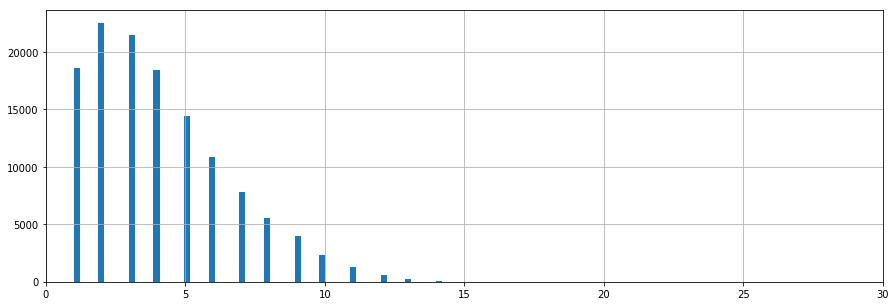

In [41]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [43]:
corpus_tokens_stem[diffs == 2]

array([list(['идиотк', 'испуга']), list(['люб', 'зна']),
       list(['ох', 'друз']), ..., list(['пасх', 'поддерж']),
       list(['хотел', 'написа']), list(['посмотр', 'вавилон'])],
      dtype=object)

In [44]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.8201190262622166

In [45]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

105145 105145


In [46]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

105145 105145


In [47]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

105145


(0, 10)

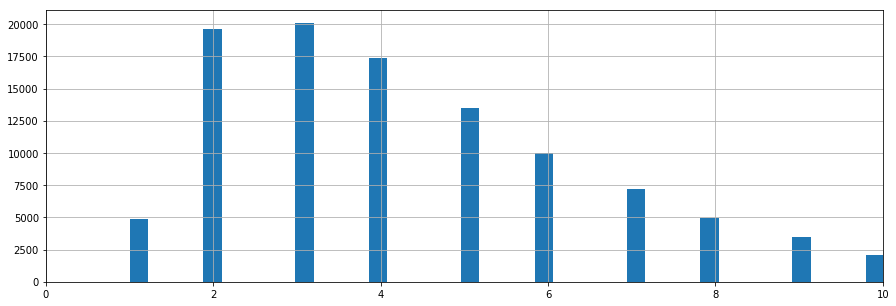

In [48]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [50]:
corpus_tokens_stem[diffs == 7]

array([list(['рад', 'пиздец', 'прям', 'искрен', 'рад', 'справедлив', 'свет']),
       list(['нашл', 'иг', 'нагл', 'фотограф', 'статус', 'вконтакт', 'быва']),
       list(['нижн', 'слякотн', 'погод', 'брр', 'привоз', 'заход', 'заход']),
       ...,
       list(['апостол', 'андре', 'правил', 'мо', 'муж', 'ангел', 'зим']),
       list(['добр', 'плох', 'пятниц', 'дни', 'плох', 'раз', 'случа']),
       list(['спал', 'родительск', 'дом', 'кроват', 'проснул', 'кошк', 'голов'])],
      dtype=object)

In [51]:
corpus_tokens_stem[diffs >= 8].shape

(12533,)

In [52]:
corp4learning = corpus_tokens_stem[diffs >= 8]
texts4learning = texts[diffs >= 8]

In [53]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [54]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

15732
